# LSTM - vanilla

In [1]:
best_model = "best_model-add-hidden-state.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


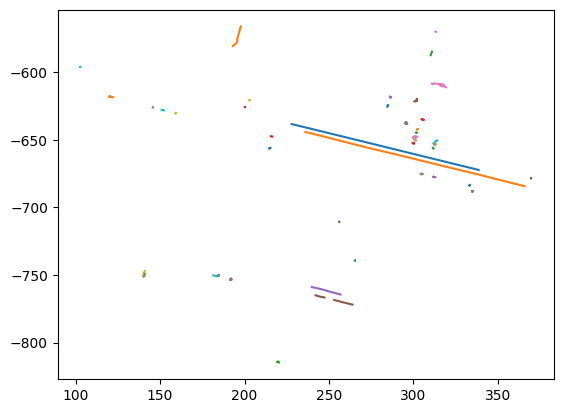

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [5]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [6]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [11]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    def forward(self, data, hidden_state = None):
        x = data.x[..., :5]
        x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        batch_size = x.shape[0]
        
        if hidden_state is None:
            h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(device)
            c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(device)
            hidden_state = (h0, c0)
            
        # Process through LSTM
        lstm_out, hidden_state = self.lstm(x)
        
        # Extract final hidden state
        features = lstm_out[:, -1, :]
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [8]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [15]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=5, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.005,
        lr=0.007,  # 8.07 val, 8.99 public
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [12]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_30493/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_30493/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/100 [00:11<18:46, 11.38s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 1.2725 | Val MSE 0.4412 | Val MAE 2.5861 | Val MSE 21.6177
Sample pred first 3 steps: [[ 0.01371775  0.01200158]
 [ 0.03005287 -0.00314961]
 [ 0.03526685 -0.0065393 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 0.441178


Epoch:   2%|▏         | 2/100 [00:21<17:22, 10.64s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.4262 | Val MSE 0.3948 | Val MAE 2.4487 | Val MSE 19.3447
Validation improved: 0.441178 -> 0.394789


Epoch:   3%|▎         | 3/100 [00:31<16:28, 10.19s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.4060 | Val MSE 0.3640 | Val MAE 2.5067 | Val MSE 17.8368
Validation improved: 0.394789 -> 0.364017


Epoch:   4%|▍         | 4/100 [00:40<15:58,  9.98s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.3791 | Val MSE 0.3304 | Val MAE 2.1666 | Val MSE 16.1874
Validation improved: 0.364017 -> 0.330355


Epoch:   5%|▌         | 5/100 [00:49<15:00,  9.47s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.3438 | Val MSE 0.2993 | Val MAE 2.0478 | Val MSE 14.6675
Validation improved: 0.330355 -> 0.299338


Epoch:   6%|▌         | 6/100 [00:57<14:13,  9.08s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.3299 | Val MSE 0.2706 | Val MAE 1.9025 | Val MSE 13.2579
Sample pred first 3 steps: [[ 0.00197935  0.00160713]
 [-0.00021026 -0.00273086]
 [ 0.00353802 -0.00411725]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.299338 -> 0.270570


Epoch:   7%|▋         | 7/100 [01:06<13:45,  8.87s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.3112 | Val MSE 0.3104 | Val MAE 2.2194 | Val MSE 15.2100


Epoch:   8%|▊         | 8/100 [01:14<13:13,  8.62s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.3069 | Val MSE 0.2481 | Val MAE 1.7404 | Val MSE 12.1583
Validation improved: 0.270570 -> 0.248128


Epoch:   9%|▉         | 9/100 [01:22<12:44,  8.40s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.2907 | Val MSE 0.2642 | Val MAE 1.8726 | Val MSE 12.9438


Epoch:  10%|█         | 10/100 [01:30<12:40,  8.45s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.2889 | Val MSE 0.2660 | Val MAE 1.8655 | Val MSE 13.0345


Epoch:  11%|█         | 11/100 [01:39<12:27,  8.40s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.2818 | Val MSE 0.2363 | Val MAE 1.7867 | Val MSE 11.5794
Sample pred first 3 steps: [[-0.00479507  0.00421923]
 [-0.00896386  0.00544912]
 [-0.00744205  0.00814738]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.248128 -> 0.236314


Epoch:  12%|█▏        | 12/100 [01:46<12:02,  8.21s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.2759 | Val MSE 0.2615 | Val MAE 1.9166 | Val MSE 12.8149


Epoch:  13%|█▎        | 13/100 [01:54<11:42,  8.07s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.2673 | Val MSE 0.2257 | Val MAE 1.6726 | Val MSE 11.0593
Validation improved: 0.236314 -> 0.225700


Epoch:  14%|█▍        | 14/100 [02:02<11:36,  8.10s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.2650 | Val MSE 0.2289 | Val MAE 1.7541 | Val MSE 11.2144


Epoch:  15%|█▌        | 15/100 [02:10<11:27,  8.09s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.2579 | Val MSE 0.2215 | Val MAE 1.6866 | Val MSE 10.8554
Validation improved: 0.225700 -> 0.221538


Epoch:  16%|█▌        | 16/100 [02:19<11:29,  8.21s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.2508 | Val MSE 0.2184 | Val MAE 1.6560 | Val MSE 10.7035
Sample pred first 3 steps: [[ 0.00013914 -0.00391567]
 [ 0.00085144  0.00500507]
 [-0.0021423   0.00876278]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.221538 -> 0.218438


Epoch:  17%|█▋        | 17/100 [02:27<11:23,  8.23s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.2989 | Val MSE 0.2014 | Val MAE 1.5546 | Val MSE 9.8665
Validation improved: 0.218438 -> 0.201357


Epoch:  18%|█▊        | 18/100 [02:35<11:17,  8.26s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.2428 | Val MSE 0.2159 | Val MAE 1.7324 | Val MSE 10.5790


Epoch:  19%|█▉        | 19/100 [02:44<11:19,  8.39s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.2400 | Val MSE 0.2133 | Val MAE 1.6653 | Val MSE 10.4495


Epoch:  20%|██        | 20/100 [02:52<11:03,  8.29s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.2365 | Val MSE 0.2085 | Val MAE 1.7193 | Val MSE 10.2148


Epoch:  21%|██        | 21/100 [03:01<10:58,  8.34s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.2298 | Val MSE 0.2042 | Val MAE 1.5493 | Val MSE 10.0082
Sample pred first 3 steps: [[-0.00227097  0.00120934]
 [-0.00320292 -0.00534219]
 [-0.00549698 -0.00687845]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [03:09<10:59,  8.46s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.2274 | Val MSE 0.2028 | Val MAE 1.5350 | Val MSE 9.9354


Epoch:  23%|██▎       | 23/100 [03:18<10:49,  8.44s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.2210 | Val MSE 0.2303 | Val MAE 1.6443 | Val MSE 11.2826


Epoch:  24%|██▍       | 24/100 [03:26<10:31,  8.31s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.2166 | Val MSE 0.2211 | Val MAE 1.8129 | Val MSE 10.8346


Epoch:  25%|██▌       | 25/100 [03:34<10:24,  8.32s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.2190 | Val MSE 0.1854 | Val MAE 1.4633 | Val MSE 9.0837
Validation improved: 0.201357 -> 0.185382


Epoch:  26%|██▌       | 26/100 [03:42<10:13,  8.29s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.2159 | Val MSE 0.1914 | Val MAE 1.5271 | Val MSE 9.3773
Sample pred first 3 steps: [[ 0.00159485  0.00436884]
 [ 0.00378     0.00241866]
 [ 0.00053038 -0.00341358]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  27%|██▋       | 27/100 [03:49<09:39,  7.94s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.2130 | Val MSE 0.2089 | Val MAE 1.6123 | Val MSE 10.2366


Epoch:  28%|██▊       | 28/100 [03:56<09:04,  7.56s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.2129 | Val MSE 0.1849 | Val MAE 1.4396 | Val MSE 9.0615
Validation improved: 0.185382 -> 0.184929


Epoch:  29%|██▉       | 29/100 [04:03<08:44,  7.39s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.2075 | Val MSE 0.1894 | Val MAE 1.4998 | Val MSE 9.2793


Epoch:  30%|███       | 30/100 [04:10<08:19,  7.14s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.2080 | Val MSE 0.1803 | Val MAE 1.4377 | Val MSE 8.8360
Validation improved: 0.184929 -> 0.180326


Epoch:  31%|███       | 31/100 [04:17<08:09,  7.10s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.2046 | Val MSE 0.1837 | Val MAE 1.4724 | Val MSE 9.0004
Sample pred first 3 steps: [[-0.00134747  0.00236208]
 [-0.00291029  0.00701666]
 [-0.00457657  0.00455015]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  32%|███▏      | 32/100 [04:24<08:03,  7.11s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.2041 | Val MSE 0.1826 | Val MAE 1.4930 | Val MSE 8.9486


Epoch:  33%|███▎      | 33/100 [04:30<07:39,  6.86s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.2023 | Val MSE 0.1886 | Val MAE 1.4707 | Val MSE 9.2399


Epoch:  34%|███▍      | 34/100 [04:36<07:19,  6.66s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.2006 | Val MSE 0.1895 | Val MAE 1.5119 | Val MSE 9.2852


Epoch:  35%|███▌      | 35/100 [04:43<07:10,  6.62s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.1994 | Val MSE 0.1823 | Val MAE 1.4270 | Val MSE 8.9350


Epoch:  36%|███▌      | 36/100 [04:49<07:00,  6.57s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.1995 | Val MSE 0.1821 | Val MAE 1.4482 | Val MSE 8.9221
Sample pred first 3 steps: [[-3.5989564e-05 -3.1341293e-03]
 [ 2.3471727e-03  1.0693143e-03]
 [ 2.1984319e-03  3.5063829e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [04:56<06:55,  6.59s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.1966 | Val MSE 0.1781 | Val MAE 1.4191 | Val MSE 8.7289
Validation improved: 0.180326 -> 0.178142


Epoch:  38%|███▊      | 38/100 [05:02<06:46,  6.56s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.1967 | Val MSE 0.1806 | Val MAE 1.4507 | Val MSE 8.8479


Epoch:  39%|███▉      | 39/100 [05:09<06:33,  6.45s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.1942 | Val MSE 0.1734 | Val MAE 1.3728 | Val MSE 8.4984
Validation improved: 0.178142 -> 0.173437


Epoch:  40%|████      | 40/100 [05:15<06:33,  6.56s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.1933 | Val MSE 0.1794 | Val MAE 1.4310 | Val MSE 8.7885


Epoch:  41%|████      | 41/100 [05:22<06:23,  6.51s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.1924 | Val MSE 0.1744 | Val MAE 1.3959 | Val MSE 8.5450
Sample pred first 3 steps: [[-0.00127515 -0.00050598]
 [-0.00152907 -0.00294332]
 [-0.0041017  -0.00283986]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  42%|████▏     | 42/100 [05:28<06:14,  6.46s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.1902 | Val MSE 0.1787 | Val MAE 1.3969 | Val MSE 8.7575


Epoch:  43%|████▎     | 43/100 [05:34<06:01,  6.35s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.1887 | Val MSE 0.1788 | Val MAE 1.4081 | Val MSE 8.7612


Epoch:  44%|████▍     | 44/100 [05:40<05:49,  6.23s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.1912 | Val MSE 0.1733 | Val MAE 1.3995 | Val MSE 8.4922
Validation improved: 0.173437 -> 0.173310


Epoch:  45%|████▌     | 45/100 [05:46<05:40,  6.19s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.1894 | Val MSE 0.1769 | Val MAE 1.4250 | Val MSE 8.6675


Epoch:  46%|████▌     | 46/100 [05:53<05:35,  6.22s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.1886 | Val MSE 0.1700 | Val MAE 1.3576 | Val MSE 8.3314
Sample pred first 3 steps: [[-0.0004175  -0.00026289]
 [-0.00158042 -0.00060192]
 [-0.00261436 -0.00299784]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.173310 -> 0.170029


Epoch:  47%|████▋     | 47/100 [05:59<05:26,  6.16s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.1839 | Val MSE 0.1689 | Val MAE 1.3469 | Val MSE 8.2762
Validation improved: 0.170029 -> 0.168903


Epoch:  48%|████▊     | 48/100 [06:05<05:20,  6.17s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1869 | Val MSE 0.1707 | Val MAE 1.3377 | Val MSE 8.3627


Epoch:  49%|████▉     | 49/100 [06:11<05:19,  6.26s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.1840 | Val MSE 0.1698 | Val MAE 1.3585 | Val MSE 8.3212


Epoch:  50%|█████     | 50/100 [06:19<05:37,  6.74s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.1846 | Val MSE 0.1703 | Val MAE 1.3688 | Val MSE 8.3456


Epoch:  51%|█████     | 51/100 [06:26<05:32,  6.79s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.1835 | Val MSE 0.1755 | Val MAE 1.3713 | Val MSE 8.5984
Sample pred first 3 steps: [[-0.00170769  0.00056567]
 [-0.00285117  0.00036142]
 [-0.00404188 -0.00085465]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  52%|█████▏    | 52/100 [06:33<05:27,  6.82s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.1832 | Val MSE 0.1695 | Val MAE 1.3519 | Val MSE 8.3031


Epoch:  53%|█████▎    | 53/100 [06:40<05:23,  6.88s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.1814 | Val MSE 0.1725 | Val MAE 1.3864 | Val MSE 8.4503


Epoch:  54%|█████▍    | 54/100 [06:46<05:12,  6.79s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.1815 | Val MSE 0.1716 | Val MAE 1.3551 | Val MSE 8.4099


Epoch:  55%|█████▌    | 55/100 [06:54<05:16,  7.03s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.1813 | Val MSE 0.1725 | Val MAE 1.3847 | Val MSE 8.4507


Epoch:  56%|█████▌    | 56/100 [07:01<05:08,  7.00s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.1797 | Val MSE 0.1688 | Val MAE 1.3456 | Val MSE 8.2716
Sample pred first 3 steps: [[-0.00054331  0.00103576]
 [-0.00117953  0.0023212 ]
 [-0.00195411  0.00339616]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.168903 -> 0.168809


Epoch:  57%|█████▋    | 57/100 [07:08<04:57,  6.92s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.1801 | Val MSE 0.1695 | Val MAE 1.3705 | Val MSE 8.3069


Epoch:  58%|█████▊    | 58/100 [07:15<04:50,  6.93s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.1793 | Val MSE 0.1711 | Val MAE 1.3544 | Val MSE 8.3863


Epoch:  59%|█████▉    | 59/100 [07:21<04:40,  6.85s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.1797 | Val MSE 0.1683 | Val MAE 1.3526 | Val MSE 8.2459
Validation improved: 0.168809 -> 0.168283


Epoch:  60%|██████    | 60/100 [07:28<04:34,  6.87s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.1780 | Val MSE 0.1667 | Val MAE 1.3325 | Val MSE 8.1678
Validation improved: 0.168283 -> 0.166690


Epoch:  61%|██████    | 61/100 [07:35<04:30,  6.93s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.1775 | Val MSE 0.1689 | Val MAE 1.3366 | Val MSE 8.2744
Sample pred first 3 steps: [[ 8.9398178e-05 -1.5111087e-03]
 [ 7.2551228e-04 -2.0966486e-03]
 [ 1.1470226e-03 -2.6951432e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  62%|██████▏   | 62/100 [07:42<04:19,  6.82s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.1781 | Val MSE 0.1735 | Val MAE 1.3776 | Val MSE 8.5025


Epoch:  63%|██████▎   | 63/100 [07:49<04:13,  6.84s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.1779 | Val MSE 0.1701 | Val MAE 1.3716 | Val MSE 8.3344


Epoch:  64%|██████▍   | 64/100 [07:55<04:03,  6.77s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.1753 | Val MSE 0.1685 | Val MAE 1.3400 | Val MSE 8.2588


Epoch:  65%|██████▌   | 65/100 [08:02<03:53,  6.69s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.1751 | Val MSE 0.1679 | Val MAE 1.3340 | Val MSE 8.2277


Epoch:  66%|██████▌   | 66/100 [08:09<03:55,  6.92s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.1764 | Val MSE 0.1684 | Val MAE 1.3315 | Val MSE 8.2534
Sample pred first 3 steps: [[-0.00049644 -0.00021033]
 [-0.00097199 -0.00120203]
 [-0.00101257 -0.00108883]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  67%|██████▋   | 67/100 [08:16<03:49,  6.95s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.1746 | Val MSE 0.1711 | Val MAE 1.3502 | Val MSE 8.3818


Epoch:  68%|██████▊   | 68/100 [08:23<03:41,  6.91s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.1759 | Val MSE 0.1690 | Val MAE 1.3578 | Val MSE 8.2822


Epoch:  69%|██████▉   | 69/100 [08:30<03:31,  6.83s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.1748 | Val MSE 0.1697 | Val MAE 1.3595 | Val MSE 8.3173


Epoch:  70%|███████   | 70/100 [08:37<03:26,  6.89s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.1737 | Val MSE 0.1663 | Val MAE 1.3283 | Val MSE 8.1497
Validation improved: 0.166690 -> 0.166319


Epoch:  71%|███████   | 71/100 [08:43<03:14,  6.72s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.1739 | Val MSE 0.1668 | Val MAE 1.3270 | Val MSE 8.1728
Sample pred first 3 steps: [[-0.00063841 -0.00034329]
 [-0.00161302 -0.00070704]
 [-0.00210318 -0.00143045]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  72%|███████▏  | 72/100 [08:49<03:03,  6.54s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.1735 | Val MSE 0.1681 | Val MAE 1.3411 | Val MSE 8.2366


Epoch:  73%|███████▎  | 73/100 [08:55<02:53,  6.44s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.1745 | Val MSE 0.1661 | Val MAE 1.3240 | Val MSE 8.1410
Validation improved: 0.166319 -> 0.166143


Epoch:  74%|███████▍  | 74/100 [09:02<02:45,  6.38s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.1736 | Val MSE 0.1657 | Val MAE 1.3475 | Val MSE 8.1187
Validation improved: 0.166143 -> 0.165688


Epoch:  75%|███████▌  | 75/100 [09:08<02:37,  6.32s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.1720 | Val MSE 0.1666 | Val MAE 1.3277 | Val MSE 8.1613


Epoch:  76%|███████▌  | 76/100 [09:14<02:33,  6.38s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.1743 | Val MSE 0.1683 | Val MAE 1.3302 | Val MSE 8.2449
Sample pred first 3 steps: [[-3.4700293e-05 -8.7370188e-04]
 [ 9.0763904e-04 -1.5989458e-03]
 [ 1.5785906e-03 -2.3137359e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  77%|███████▋  | 77/100 [09:22<02:31,  6.59s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.1734 | Val MSE 0.1670 | Val MAE 1.3179 | Val MSE 8.1842


Epoch:  78%|███████▊  | 78/100 [09:28<02:25,  6.63s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.1742 | Val MSE 0.1671 | Val MAE 1.3492 | Val MSE 8.1890


Epoch:  79%|███████▉  | 79/100 [09:35<02:19,  6.64s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.1728 | Val MSE 0.1655 | Val MAE 1.3165 | Val MSE 8.1095
Validation improved: 0.165688 -> 0.165499


Epoch:  80%|████████  | 80/100 [09:41<02:11,  6.57s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.1728 | Val MSE 0.1661 | Val MAE 1.3268 | Val MSE 8.1388


Epoch:  81%|████████  | 81/100 [09:47<02:00,  6.37s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.1709 | Val MSE 0.1672 | Val MAE 1.3249 | Val MSE 8.1932
Sample pred first 3 steps: [[-0.00139279 -0.00037797]
 [-0.00306428 -0.00119337]
 [-0.0039643  -0.00205666]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  82%|████████▏ | 82/100 [09:53<01:51,  6.21s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.1730 | Val MSE 0.1664 | Val MAE 1.3193 | Val MSE 8.1527


Epoch:  83%|████████▎ | 83/100 [10:00<01:49,  6.44s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.1698 | Val MSE 0.1660 | Val MAE 1.3133 | Val MSE 8.1332


Epoch:  84%|████████▍ | 84/100 [10:07<01:46,  6.64s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.1703 | Val MSE 0.1664 | Val MAE 1.3153 | Val MSE 8.1539


Epoch:  85%|████████▌ | 85/100 [10:14<01:38,  6.58s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.1710 | Val MSE 0.1676 | Val MAE 1.3288 | Val MSE 8.2133


Epoch:  86%|████████▌ | 86/100 [10:21<01:36,  6.91s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.1723 | Val MSE 0.1670 | Val MAE 1.3255 | Val MSE 8.1817
Sample pred first 3 steps: [[-0.00053115 -0.0002467 ]
 [-0.00140297 -0.00051759]
 [-0.00177238 -0.00019611]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  87%|████████▋ | 87/100 [10:28<01:29,  6.92s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.1708 | Val MSE 0.1665 | Val MAE 1.3245 | Val MSE 8.1594


Epoch:  88%|████████▊ | 88/100 [10:35<01:23,  6.92s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.1721 | Val MSE 0.1663 | Val MAE 1.3086 | Val MSE 8.1477


Epoch:  89%|████████▉ | 89/100 [10:42<01:16,  6.93s/epoch]

Epoch 088 | LR 0.000073 | Train MSE 0.1694 | Val MSE 0.1675 | Val MAE 1.3138 | Val MSE 8.2094


Epoch:  90%|█████████ | 90/100 [10:49<01:08,  6.83s/epoch]

Epoch 089 | LR 0.000069 | Train MSE 0.1696 | Val MSE 0.1661 | Val MAE 1.3308 | Val MSE 8.1405


Epoch:  91%|█████████ | 91/100 [10:55<01:01,  6.81s/epoch]

Epoch 090 | LR 0.000066 | Train MSE 0.1720 | Val MSE 0.1660 | Val MAE 1.3128 | Val MSE 8.1327
Sample pred first 3 steps: [[-0.00089934 -0.00021711]
 [-0.00150747 -0.00042328]
 [-0.00218722 -0.00051469]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  92%|█████████▏| 92/100 [11:02<00:53,  6.64s/epoch]

Epoch 091 | LR 0.000062 | Train MSE 0.1704 | Val MSE 0.1655 | Val MAE 1.3109 | Val MSE 8.1099


Epoch:  93%|█████████▎| 93/100 [11:09<00:47,  6.72s/epoch]

Epoch 092 | LR 0.000059 | Train MSE 0.1703 | Val MSE 0.1668 | Val MAE 1.3144 | Val MSE 8.1727


Epoch:  94%|█████████▍| 94/100 [11:15<00:39,  6.65s/epoch]

Epoch 093 | LR 0.000056 | Train MSE 0.1702 | Val MSE 0.1658 | Val MAE 1.3115 | Val MSE 8.1255


Epoch:  95%|█████████▌| 95/100 [11:22<00:33,  6.63s/epoch]

Epoch 094 | LR 0.000054 | Train MSE 0.1707 | Val MSE 0.1649 | Val MAE 1.3012 | Val MSE 8.0811
Validation improved: 0.165499 -> 0.164920


Epoch:  96%|█████████▌| 96/100 [11:28<00:26,  6.69s/epoch]

Epoch 095 | LR 0.000051 | Train MSE 0.1709 | Val MSE 0.1649 | Val MAE 1.3033 | Val MSE 8.0798
Sample pred first 3 steps: [[-0.00078795 -0.00049837]
 [-0.00118741 -0.00086113]
 [-0.0014339  -0.00098583]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.164920 -> 0.164894


Epoch:  97%|█████████▋| 97/100 [11:35<00:20,  6.77s/epoch]

Epoch 096 | LR 0.000048 | Train MSE 0.1691 | Val MSE 0.1651 | Val MAE 1.3125 | Val MSE 8.0877


Epoch:  98%|█████████▊| 98/100 [11:42<00:13,  6.82s/epoch]

Epoch 097 | LR 0.000046 | Train MSE 0.1689 | Val MSE 0.1668 | Val MAE 1.3270 | Val MSE 8.1711


Epoch:  99%|█████████▉| 99/100 [11:49<00:06,  6.72s/epoch]

Epoch 098 | LR 0.000044 | Train MSE 0.1687 | Val MSE 0.1665 | Val MAE 1.3161 | Val MSE 8.1577


Epoch: 100%|██████████| 100/100 [11:55<00:00,  7.16s/epoch]


Epoch 099 | LR 0.000041 | Train MSE 0.1701 | Val MSE 0.1663 | Val MAE 1.3055 | Val MSE 8.1464
Val MSE: 8.0798


SimpleLSTM(
  (lstm): LSTM(5, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=120, bias=True)
)

# Final Pred

In [14]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto9-optional.csv', index=True)